In [1]:
#####################
# IMPORT LIBS
#####################

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K
import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import albumentations as A
import cv2
import wandb
from wandb.keras import WandbCallback
import datetime



#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH / 'idao_dataset' / 'train'
PRIVATE_PATH = INPUT_PATH / 'idao_dataset' / 'private_test'
PRIVATE_PATH_NEW = INPUT_PATH / 'idao_dataset' / 'private_test_new'
PUBLIC_PATH = INPUT_PATH / 'idao_dataset' / 'public_test'

RANDOM_SEED = 4444
USE_WANDB = True

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)


if USE_WANDB:
    CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]
    RUN_NAME = 'track_2_MobileNetV2'

    wandb.login()
    run = wandb.init(project="idao-classification", name = f'{RUN_NAME}_{CURRENT_TIME}')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


wandb: Currently logged in as: artkulak (use `wandb login --relogin` to force relogin)


In [2]:
class Config:
    BATCH_SIZE = 64
    TRAINING_EPOCHS = 150
    VALIDATION_STEPS_PER_EPOCH = 5
    VALIDATION_EPOCHS = 10
    STEPS_PER_EPOCH = 30
    EARLY_STOP_PATIENCE = 15
    
    
    # Declare an augmentation pipeline
    train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        A.Cutout(num_holes=4, max_h_size=8, max_w_size=8, p=0.3),
        A.OneOf([A.RandomContrast(),
             A.RandomGamma(),
             A.RandomBrightness()],p=0.2),
        A.OneOf([A.Blur(p = 0.3),
             A.GaussNoise(p=0.3)
                ],p=0.5),
        A.CLAHE(clip_limit=4, tile_grid_size=(8,8), always_apply=False, p=0.3),
    ],)
    
    validation_transform = A.Compose([
    ],)

In [3]:
def getFeatures(img_path):
    if len(img_path.split('_')) == 18:
        particle_class = 1 # ER
        particle_energy = int(img_path.split('_')[7])
    else:
        particle_class = 0 # HE
        particle_energy = int(img_path.split('_')[8])
    return [img_path, particle_class, particle_energy]

images = glob.glob(str(TRAIN_PATH / '**/*.png'), recursive=True)
images = pd.DataFrame(map(getFeatures, images))
images.columns = ['path', 'class', 'energy']

In [4]:
#################
# EXTRACT TEST
#################

# HE - 0, ER - 1

he_test_idx = list(images[(images['class'] == 0) & (images['energy'].apply(lambda x: x in [3, 10, 30]))].index)
er_test_idx = list(images[(images['class'] == 1) & (images['energy'].apply(lambda x: x in [1, 6, 20]))].index)

In [9]:
test_idx = he_test_idx + er_test_idx
test_images = images.iloc[test_idx]

In [10]:
images = images.drop(index = test_idx)

train_images, valid_images = train_test_split(images, shuffle = True, random_state = RANDOM_SEED)
train_images = train_images.reset_index(drop = True)
valid_images = valid_images.reset_index(drop = True)

In [11]:
def calc_metric(y_binary_true, y_binary_pred, y_reg_true, y_reg_pred):
    '''
    Competition metric
    '''
    
    roc = roc_auc_score(y_binary_true, y_binary_pred)
    mae = mean_absolute_error(y_reg_true, y_reg_pred)
    return 1000 * (roc - mae), roc, mae

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, transform=None, batch_size=32,  shuffle=True, is_classification = True, augment = False):
        self.images = images
        self.indices = np.arange(len(images))
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.is_classification = is_classification
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
    
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = np.zeros((self.batch_size, 128, 128, 3))
        y_class = np.zeros((self.batch_size,))
        y_energy = np.zeros((self.batch_size))
        for i, idx in enumerate(batch):
            image=cv2.imread(self.images.iloc[idx, 0])
            center = image.shape[0] // 2
            image = image[center-128//2:center+128//2,center-128//2:center+128//2, :]
            X[i,] = image
            
            if self.augment:
                X[i, ] = Config.train_transform(image=X[i,].astype(np.uint8))['image']
            particle_class = self.images.iloc[idx, 1]
            particle_energy = self.images.iloc[idx, 2]
            y_class[i] = particle_class
            y_energy[i] = particle_energy
        if self.is_classification:
            return X / 255.0, y_class
        return X / 255.0, y_energy


In [13]:
train_datagen = DataGenerator(train_images, batch_size = Config.BATCH_SIZE, is_classification = True, augment = False)
valid_datagen = DataGenerator(valid_images, batch_size = Config.BATCH_SIZE, is_classification = True)
test_datagen = DataGenerator(test_images, batch_size = 1, is_classification = True, shuffle = False)

In [14]:
# Example data extract

X, y_class = train_datagen.__getitem__(0)

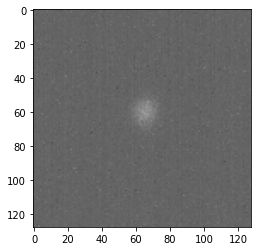

In [15]:
idx = 17
plt.imshow((X[idx] * 255).astype(np.uint8))

## Class model

In [16]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet152V2, ResNet50
from tensorflow.keras.applications import NASNetLarge, EfficientNetB3, InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201

from tensorflow.keras.applications import EfficientNetB0
import numpy as np

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
MODEL_NAME = 'classification_track2_MobileNetV2'

In [17]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras
import tensorflow
from tensorflow.keras import regularizers

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_auc', patience=Config.EARLY_STOP_PATIENCE)
ckpt = tensorflow.keras.callbacks.ModelCheckpoint(OUTPUT_PATH / 'models' / MODEL_NAME, save_best_only=True, monitor='val_auc', mode='max')
    
def create_classification_model(base_model, l2_loss_lambda = 1e-4):
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = L.GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = L.Dense(512, activation='relu')(x)
    x = L.Dense(64, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = L.Dense(1, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)


    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=1e-3), loss='binary_crossentropy', metrics = ['AUC'])
    return model

In [18]:
model = create_classification_model(base_model)

In [19]:
class ModelCustomEval(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        private_test_loss, private_test_auc = self.model.evaluate(test_datagen, batch_size=8, steps=test_images.shape[0])
        wandb.log({'private_test_loss': private_test_loss, 'private_test_auc': private_test_auc})
        
        print(f'Private test AUC is {private_test_auc}')

In [20]:
if USE_WANDB:
    model.fit(
        train_datagen, 
        steps_per_epoch = Config.STEPS_PER_EPOCH, 
        validation_data = valid_datagen_public, 
        validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
        epochs = Config.TRAINING_EPOCHS,
        verbose = 1,
        callbacks = [earlystop, ckpt, WandbCallback(), ModelCustomEval()]
        )
else:
    model.fit(
        train_datagen, 
        steps_per_epoch = Config.STEPS_PER_EPOCH, 
        validation_data = valid_datagen_public, 
        validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
        epochs = Config.TRAINING_EPOCHS,
        verbose = 1,
        callbacks = [earlystop, ckpt]
        )

In [21]:
model = tensorflow.keras.models.load_model(OUTPUT_PATH / 'models' / MODEL_NAME)

In [22]:
model.evaluate(valid_datagen, batch_size=Config.BATCH_SIZE, steps=Config.VALIDATION_STEPS_PER_EPOCH)

5/5 [==============================] - 2s 192ms/step - loss: 0.2662 - auc: 0.9669


[0.2662123739719391, 0.9669359922409058]

In [24]:
private_test_loss, private_test_auc = model.evaluate(test_datagen, batch_size=1, steps=test_images.shape[0])
wandb.run.summary["private_test_auc"] = private_test_auc

12/12 [==============================] - 0s 6ms/step - loss: 0.2977 - auc: 1.0000


In [25]:
y_pred = model.predict(test_datagen)
print(y_pred)

[[0.27454406]
 [0.39387158]
 [0.02689447]
 [0.10773389]
 [0.9809776 ]
 [0.8730674 ]
 [0.86078906]
 [0.937324  ]
 [0.9991479 ]
 [0.34194642]
 [0.28601393]
 [0.328441  ]]


In [26]:
if USE_WANDB:
    run.finish()

## Score calc

In [51]:
auc = lambda score_orig, score_swapped: score_orig/1000 + 1/2 * (1 - (score_swapped + score_orig)/1000) 
mae = lambda score_orig, score_swapped: 1/2 * (1 - (score_swapped + score_orig)/1000) 

In [54]:
auc(-98.88, -1006.54)

0.9538300000000001

In [55]:
mae(-98.88, -1006.54)

1.05271